In [ ]:
theta_0 = 0.5  # true location parameter
n_set = c(20,50,100,200,500,1000)  # set of sample sizes in the experiment
mc_times = 20  # number of Monte Carlo simulations

In [ ]:
# the necessary R package for generating Laplace distributed random variables
install.packages("VGAM")
library("VGAM")

generate_laplace <- function(n, theta_0){
  # generate n iid Laplace random variables with mean theta_0 and variance 1
  sample = rlaplace(n, location = theta_0, scale = 1)
  sample = pmin(pmax(sample,-5),5) # thresholding to avoid numeric issues
  return(sample)
}

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [ ]:
# this function estimates the density f(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(dnorm(x - sample, sd = sqrt(bw))) )
}

# this function estimates the density derivative f'(x) based on the sample
# bw is the bandwidth parameter used in the computation
density_deriv_est <- function(x, sample, bw) {
  x = x + median(sample)
  return( mean(-((x-sample)/(bw^2)) * dnorm(x - sample, sd = sqrt(bw))))
}

# this function outputs the semiparametric estimate of theta_0
semiparametric_estimate <- function(sample){
  bw = density(sample)$bw # set the bandwidth parameter

  # YOUR CODE (5-10 lines):
  # based on the estimates of the density and derivative, use Stein's estimating
  # equation to compute the semiparametric estimate of theta_0
  #
  # Note: the "uniroot" function finding the zero of a 1D function might be useful:
  # https://stat.ethz.ch/R-manual/R-devel/library/stats/html/uniroot.html
  # In uniroot, you may set interval = c(-10, 10)
  est_eqn <- function(x) {
    est = numeric(length(sample))
    for (s in 1:length(sample)) {
      est[s] = density_deriv_est(sample[s]-x, sample, bw)/density_est(sample[s]-x, sample, bw)
    }
    return (mean(est))
  }
  result = uniroot(est_eqn, interval = c(-10, 10))
  theta_hat = result$root
  return(theta_hat)
}

In [ ]:
library("ggplot2")
set.seed("2023")

# YOUR CODE (~20 lines):
# 1. for each value n in n_set, generate a sample of size n with truth theta_0
# 2. compute three estimators based on the sample:
### 2.1. the sample average;
### 2.2. the MLE with known f (you are supposed to derive the MLE in this case
### by hand, which should be a very simple function of the sample)
### 2.3. Stein's semiparametric estimator.
# 3. repeat the above procedure for mc_times=20 times, and output the mean
# squared error for each (n, estimator) pair (so 6*3 matrix in total)
# 4. use ggplot, draw (mean squared error ~ n) in a line chart with log-log scale;
# all three curves for different estimators should be in te same plot
# Note: the overall runtime might take several minutes, so it is advised to
# start from small-scale experiments

mse_results = matrix(0, nrow = length(n_set), ncol = 3)
for (i in seq_along(n_set)){
  n = n_set[i]

  mse_average = mse_mle = mse_stein = numeric(mc_times)

  for (mc_i in 1:mc_times) {
    sample_data = generate_laplace(n, theta_0)

    est_average = mean(sample_data)
    est_mle = median(sample_data)
    est_stein = semiparametric_estimate(sample_data)

    mse_average[mc_i] = (est_average - theta_0)^2
    mse_mle[mc_i] = (est_mle - theta_0)^2
    mse_stein[mc_i] = (est_stein - theta_0)^2
  }
  mse_results[i, 1] = mean(mse_average)
  mse_results[i, 2] = mean(mse_mle)
  mse_results[i, 3] = mean(mse_stein)
}
mse_results

0.115160207,0.0835717270,0.0870167516
0.063088821,0.0549321444,0.0524528359
0.021959140,0.0212305227,0.0213482236
0.011983927,0.0050432546,0.0051399898
0.004194129,0.0015086628,0.0015391695
0.001229243,0.0007579703,0.0008097898


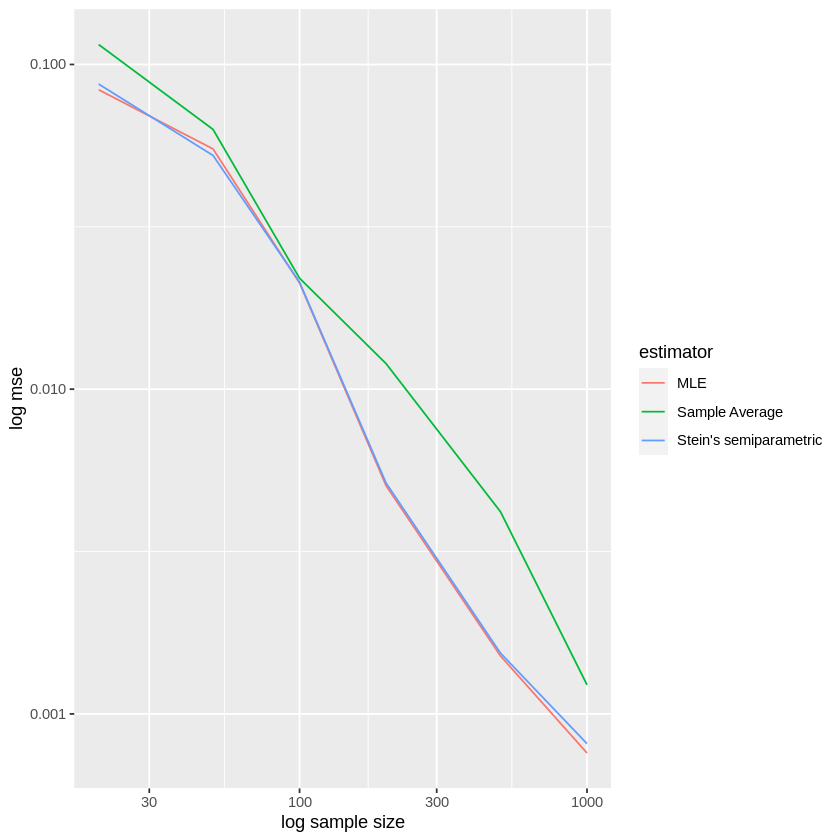

In [ ]:
df <- data.frame(
  n = rep(c(20, 50, 100, 200, 500, 1000), each = 3),
  mse = as.vector(t(mse_results)),
  estimator = rep(c("Sample Average", "MLE", "Stein's semiparametric"), times = 6)
  )

ggplot(df, aes(x = n, y = mse, color = estimator)) +
  geom_line() +
  scale_x_log10() +
  scale_y_log10() +
  labs(x = "log sample size", y = "log mse")

### Code Link
https://colab.research.google.com/drive/1S7HCf-sauQZfzbqbKHn2lNsDy-_RT0ri?usp=sharing